In [125]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
def hadamard(A,B):
    n_dim_a = len(A.shape)
    n_dim_b = len(B.shape)
    if n_dim_a > n_dim_b:
        return B[:,None]* A
    elif n_dim_a < n_dim_b:
        return A[:,None]* B
    else:
        return A*B

# Standard Trap-Diffusion Model

In [143]:
class TrapDiffusion:
    def __init__(self, name):
        self.ts = np.linspace(0, 2, 1000)
        self.sol = None
        self.name = name
    
    def rhs(self,y,t):
        raise NotImplementedError("Subclass must implement abstract method")
    
    def jacobian(self,y,t):
        raise NotImplementedError("Subclass must implement abstract method")

    def solve(self,y0):
        self.sol = odeint(self.rhs, y0, self.ts, Dfun=self.jacobian)

    def plot_details(self):
        ...
    
    @property
    def vector_description(self):
        raise NotImplementedError("Subclass must implement abstract method")
    
    def plot(self):
        if self.sol is None:
            self.solve(self.c)
        
        for key, value in self.vector_description.items():
            plt.plot(self.ts,self.sol[:,key], label = value)
        
        self.plot_details()
        plt.legend()
        plt.ylabel("Concentration")
        plt.xlabel("Time")
        plt.title(self.name)
        plt.grid()

## Single-Oppucation, Single Isotope Model

\begin{aligned}
&\begin{aligned}
\frac{d}{d t}\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right) & =\left(\begin{array}{l}
1 / c^S \\
1 / c_1^T \\
1 / c_2^T
\end{array}\right) \circ \\
& \left\{\left(\begin{array}{ccc}
-\left(a_{T_1 S} c_1^T \sigma+a_{T_2 S} c_2^T \sigma\right) c^S & a_{S T_1} c_1^T & a_{S T_2} c_2^T \\
a_{T_1 S} c^S c_1^T \sigma & -a_{S T_1} c_1^T & 0 \\
a_{T_2 S} c^S c_2^T \sigma & 0 & -a_{S T_2} c_2^T
\end{array}\right)\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right)\right.
\end{aligned}\\
&\left.+\left[\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right) \circ\left(\begin{array}{ccc}
0 & \frac{a_{T_1 s} s^S c_1^T \sigma}{c_{t, 1}^{M a x}} & \frac{a_{T_2 s} s^S c_2^T \sigma}{c_{t, 2}^{M a x}} \\
-\frac{a_{T_1 s} c^s c_1^T \sigma}{c_{t, 1}^{M a x}} & 0 & 0 \\
-\frac{a_{T_2 s} c^T c_2^T \sigma}{c_{t, 2}^{M a x}} & 0 & 0
\end{array}\right)\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right)\right]\right\}
\end{aligned}

$$
\begin{equation}
\frac{d}{d t} \vec{c}_{s, t}=\left(\frac{1}{\vec{c}^{ S / T}}\right) \circ\left[\underline{\underline{\mathbf{A}}} \vec{c}_{s, t}+\vec{c}_{s, t} \circ \underline{\underline{\mathbf{B}}} \vec{c}_{S, t}\right] .
\end{equation}
$$

$$
\begin{equation}
\underline{\underline{\mathbf{A}}}=\underline{\underline{\tilde{A}}} \underline{\underline{\mathbf{C}}}=\left(\begin{array}{ccc}
-\left(a_{T_1 S} c_1^T \sigma+a_{T_2 S} c_2^T \sigma\right) & a_{S T_1} & a_{S T_2} \\
a_{T_1 S} c_1^T \sigma & -a_{S T_1} & 0 \\
a_{T_2} s c_2^T \sigma & 0 & -a_{S T_2}
\end{array}\right)\left(\begin{array}{ccc}
c^S & 0 & 0 \\
0 & c_1^T & 0 \\
0 & 0 & c_2^T
\end{array}\right)
\end{equation}
$$

In [150]:
class SingleOccupationSingleIsotope(TrapDiffusion):
    def __init__(self,seed = None):
        TrapDiffusion.__init__(self, "Single-Occupation, Single-Isotope Model")
        np.random.seed(seed)

        # concentraion of trap sites and solute sites.
        # c_S_T = [c_S, c_T_1, c_T_2]
        self.c_S_T = np.random.random(3)
        self.c_S_T = self.c_S_T / np.sum(self.c_S_T)
        c_S, c_T_1, c_T_2 = self.c_S_T

        # site concentration matrix
        self.C = np.diag(self.c_S_T)

        # max trap conentration, has to be greater than current concentration
        self.c_Max_1 = np.random.uniform(0,0.5)
        self.c_Max_2 = np.random.uniform(0,0.5)

        # capture cross-section of trap-site
        self.sigma = 1

        # base transition rates
        self.a = np.random.random((3,3))

        # transition rate matrix
        self.A_tilde = np.array([
            [-(self.a[1,0]* c_T_1*self.sigma + self.a[2,0]*c_T_2*self.sigma), self.a[0,1], self.a[0,2]],
            [self.a[1,0]*c_T_1*self.sigma, -self.a[0,1], 0],
            [self.a[2,0]*c_T_2*self.sigma, 0, -self.a[0,2]]
        ])

        self.A = self.A_tilde @ self.C

        self.B = np.array([
            [0, (self.a[1,0]*c_S*c_T_1*self.sigma)/ self.c_Max_1, (self.a[2,0]*c_S*c_T_2*self.sigma)/ self.c_Max_2],
            [0, 0, 0],
            [0, 0, 0]
        ])
        # fill in anty-symmetric part
        self.B[:, 0] = -self.B[0,:]

        # random start concetrations
        self.c = np.random.random(3)
        self.c[1] *= self.c_Max_1
        self.c[2] *= self.c_Max_2
        self.c[0] = 1 - self.c[1] - self.c[2]

    def rhs(self,c,t):
        return hadamard(1/self.c_S_T, self.A@c + hadamard(c,self.B@c))

    def jacobian(self,c,t):
        return hadamard(1/self.c_S_T, self.A + hadamard(np.ones(3), self.B@c) + hadamard(c,self.B))
    
    @property
    def vector_description(self):
        return {
            0: "$c_S$",
            1: "$c_{T_1}$",
            2: "$c_{T_2}$"
        }
    
    def plot_details(self):
        plt.hlines([self.c_Max_1], 0, self.ts[-1], linestyles = "dashed", color = "black")
        plt.text(self.ts[-1], self.c_Max_1, "$c^{Max}_{t,1}$")
        plt.hlines([self.c_Max_2], 0, self.ts[-1], linestyles = "dashed", color = "black")
        plt.text(self.ts[-1], self.c_Max_2, "$c^{Max}_{t,2}$")


- $c_{t,i}$ : concentration of hydrogen trapped in trap of type i
- $c_j^T$ : concentration of traps of type j
- $c_{s}$ : concentration of solute hydrogen in non-trap (solute) sites
- $c^S$ : concentration of solute sites
- $a_{i\leftarrow j}$ : transition rate from j to i, typically in matrix notation in row i and columnn j
- $c_{t,i}^{Max} $ : the upper limit (maximum) of the hydrogen concentration which can be trapped in a trap of type i (capacity limit of trap)
- $\sigma$ : capture cross-section of a trap-site

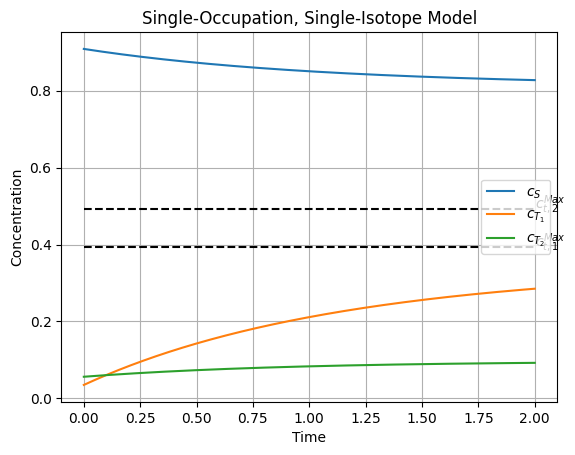

In [152]:
SingleOccupationSingleIsotope().plot()

## Single-Occupation, Multiple Isotope Model